# LSTM: Long Term Short Term Memory 

## Long term Memory problem

Reference - [`LSTM` ](https://www.youtube.com/watch?v=QciIcRxJvsM&t=306s).  

RNNs capability to connect previous information to the present task, like - time series forecasting, makes them suitable for many similar tasks. But sometimes, these tasks require current context and earlier information that RNNs cannot retain. The major problem of RNN is its need for more ability to maintain long-term details. 

In the case of a discrete system, the diagram below shows the value of $X^{(n)}$. Thus, the value either explodes to an enormous value when W > 1 or vanishes to zero when W < 1. A similar thing happens to the gradient as well. In the W > 1, the corresponding eigenvectors of the W^n explode. Thus, it implies that input in the direction of the eigenvector explodes to Infinity, and the input information is lost. While W< 1, the corresponding eigenvectors of the W^n become near zero, the input components in the eigenvectors' directions vanish, and input information is lost again.


### Data

Reference - [`Data Link` ](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/T46ANR).

Havard Dataverse is the data source of my project. The paper "Using an ensemble of artificial neural networks to convert snow depth to snow water equivalent over Canada. '' uses the same data. This dataset contains most of Canada's snow measurement and meteorological data. The information includes 2685 other stations or geographical locations and has sixteen features, such as  SWE(Snow Water Equivalent), Snow depth, Density, Day without snow, etc. The details of the data are below:

<img src="images/data_tab.png" width="700" height = "500">

## Implementation of LSTM

I used a simple model with three LSTM layers and one dense layer. The input is a time series, and the output is SWE values. Input to the model includes features such as  - snow density, snow depth, etc in ten-time stamps. This implementation is simple time series forecasting using the LSTM model. My model contains three LSTM layers with 10 neurons and a dense layer.
 

<img src="images/lstm-1.png" width="500" height = "1000">

In [2]:
# Loading data from files
canada_train_data_path = "tx_data/data_filtered_train.txt"
canada_val_data_path = "tx_data/data_filtered_val.txt"
canada_test_data_path = "tx_data/data_filtered_test.txt"

# canada_train_pd = pd.read_csv(canada_train_data_path, index_col=1)
# canada_val_pd = pd.read_csv(canada_val_data_path)
# canada_test_pd = pd.read_csv(canada_test_data_path)

In [3]:
X, Y = get_lstm_data(canada_train_data_path, 10)
print(X.shape, Y.shape)

X_v, Y_v = get_lstm_data(canada_val_data_path, 10)
print(X_v.shape, Y_v.shape)

X_t, Y_t = get_lstm_data(canada_test_data_path, 10)
print(X_t.shape, Y_t.shape)

(77133, 10, 15) (77133, 10, 1)
(76827, 10, 15) (76827, 10, 1)
(76899, 10, 15) (76899, 10, 1)


In [4]:
X_train = X
Y_train = Y[:,-1,:]
print(X_train.shape, Y_train.shape)

X_val = X_v[:7700,:,:]
Y_val = Y_v[:7700,-1,:]
print(X_val.shape, Y_val.shape)

X_test = X_t
Y_test = Y_t[:,-1,:]
print(X_test.shape, X_test.shape)

(77133, 10, 15) (77133, 1)
(7700, 10, 15) (7700, 1)
(76899, 10, 15) (76899, 10, 15)


In [5]:
# set hyperparameters
n_neuron       = 10
activation     = 'relu'
num_epochs     = 50
learning_rate  = 0.001
minibatch_size = 64
model_num      = 1

In [6]:
input_layer = tf.keras.layers.Input(shape=(X_train.shape[1],X_train.shape[2]))
lstm_1 = tf.keras.layers.LSTM(n_neuron,
               return_sequences=True, activation=activation)(input_layer)
lstm_2 = tf.keras.layers.LSTM(n_neuron, return_sequences=True,
               activation=activation)(lstm_1)
lstm_3 = tf.keras.layers.LSTM(n_neuron, return_sequences=False,
               activation=activation)(lstm_2)
dense_2 = tf.keras.layers.Dense(Y_train.shape[-1], activation='relu')(lstm_3)
model = Model(inputs=input_layer, outputs=dense_2)
model.summary()
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 15)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 10, 10)            1040      
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 10)            840       
_________________________________________________________________
lstm_2 (LSTM)                (None, 10)                840       
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 2,731
Trainable params: 2,731
Non-trainable params: 0
_________________________________________________________________


In [7]:
now = datetime.now()
best_model = "best_model/lstm_best_model-{}.h5".format(now.strftime("%d-%m-%Y-%H:%M:%S"))

In [8]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
checkpoint = tf.keras.callbacks.ModelCheckpoint(best_model, monitor='loss', verbose=True, save_best_only=True, save_weights_only=True)
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.95, patience=10, min_lr=1e-16, verbose=1)
start = time.time()
history = model.fit(X_train, Y_train, 
                        batch_size = minibatch_size,
                        epochs = num_epochs,
                        validation_data=(X_val, Y_val), verbose=1,
                        callbacks=[early_stop, checkpoint],
                        shuffle=False)
print ("Training time: {}".format(time.time() - start))

Epoch 1/50
1206/1206 [==============================] - 58s 46ms/step - loss: 0.0064 - val_loss: 8.3789e-04

Epoch 00001: loss improved from inf to 0.00354, saving model to best_model/lstm_best_model-23-12-2022-17:56:50.h5
Epoch 2/50
1206/1206 [==============================] - 55s 45ms/step - loss: 4.7741e-04 - val_loss: 7.6655e-04

Epoch 00002: loss improved from 0.00354 to 0.00043, saving model to best_model/lstm_best_model-23-12-2022-17:56:50.h5
Epoch 3/50
1206/1206 [==============================] - 55s 45ms/step - loss: 3.7629e-04 - val_loss: 7.5391e-04

Epoch 00003: loss improved from 0.00043 to 0.00034, saving model to best_model/lstm_best_model-23-12-2022-17:56:50.h5
Epoch 4/50
1206/1206 [==============================] - 55s 46ms/step - loss: 2.8116e-04 - val_loss: 7.0835e-04

Epoch 00004: loss improved from 0.00034 to 0.00023, saving model to best_model/lstm_best_model-23-12-2022-17:56:50.h5
Epoch 5/50
1206/1206 [==============================] - 55s 46ms/step - loss: 1.2046

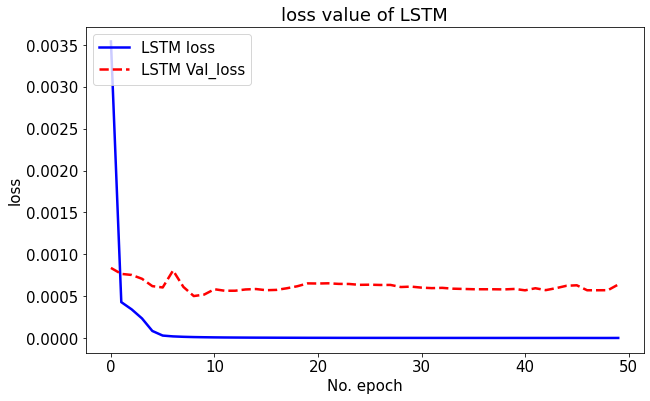

In [9]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], 'b-', linewidth=2.5, label='LSTM loss')
plt.plot(history.history['val_loss'], 'r--', linewidth=2.5, label='LSTM Val_loss')
plt.title('loss value of LSTM')
plt.ylabel('loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

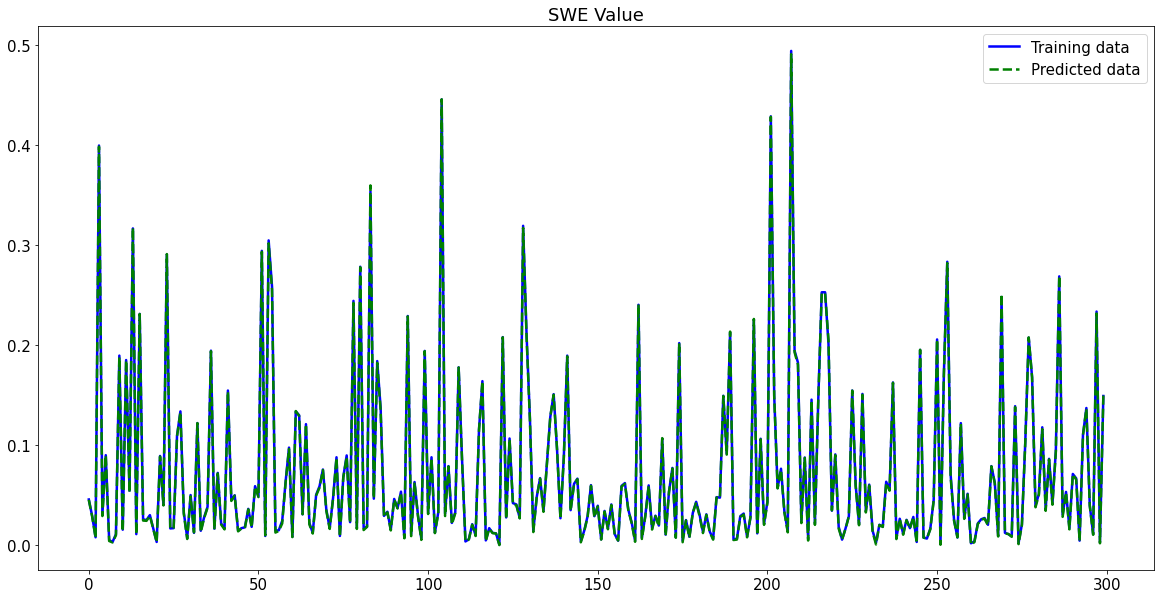

In [13]:
Y_pred = model.predict(X_train)
plt.figure(figsize=(20, 10))
# plt.plot(Y_pred[:,1], label='q_predicted')
# plt.plot(Y_train[:,1], label='q')
plt.plot(Y_train[:300,], 'b-', linewidth=2.5, label='Training data')
plt.plot(Y_pred[:300,], 'g--', linewidth=2.5, label='Predicted data')
# plt.plot(Y_test, 'r--', linewidth=2.5, label='Test data')
plt.title("SWE Value")
plt.legend()
plt.show()

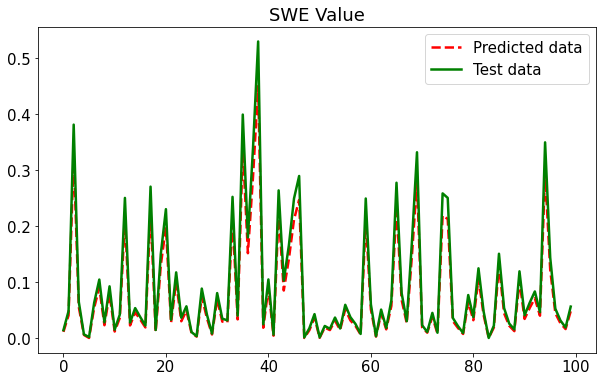

In [11]:
Y_pred_test = model.predict(X_test)
plt.figure(figsize=(10, 6))
# plt.plot(Y_pred[:,1], label='q_predicted')
# plt.plot(Y_train[:,1], label='q')
# plt.plot(Y_train[:100,], 'b-', linewidth=2.5, label='Training data')
plt.plot(Y_pred_test[:100,], 'r--', linewidth=2.5, label='Predicted data')
plt.plot(Y_test[:100], 'g-', linewidth=2.5, label='Test data')
plt.title("SWE Value")
plt.legend()
plt.show()

### Observations:

In the implementation of the LSTM, the loss = 1.7187e-06 with val_loss = 6.3943e-04. The model captured the overall nonlinear relationship between the predictors and predictand. The model's loss and deviation are slightly lower than the transformer model.